<center>
<h1>Welcome to the Lab 🥼🧪</h1>
</center>

### In this notebook, we will analyze investor ownership concentration in the Milwaukee metropolitan area.

In this notebook, we will be examining investors in the Milwaukee metro housing market, one of the metropolitan markets where large institutional investors slashed prices of their inventory [last year](https://www.parcllabs.com/articles/where-are-large-operators-cutting-home-prices). We will download information to understand the concentration of single-family homes for rental (SFRs) based on portfolio size. Specifically, we will look at the share of total housing stock by portfolio size to understand local trends.

#### Need help getting started?

As a reminder, you can get your Parcl Labs API key [here](https://dashboard.parcllabs.com/signup) to follow along.

To run this immediately, you can use Google Colab. Remember, you must set your `PARCL_LABS_API_KEY`.

Run in Colab --> [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ParclLabs/parcllabs-cookbook/blob/main/examples/housing_market_research/investor_analytics/portfolio_analysis.ipynb)


In [1]:
# if needed, install and/or upgrade to the latest verison of the Parcl Labs Python library
%pip install --upgrade parcllabs

Note: you may need to restart the kernel to use updated packages.


After installing the required libraries, we need to load them and instantiate the Parcl Labs client. The client is a Python library designed to facilitate and optimize the user experience with the Parcl Labs API. It takes care of searching, retrieving, and formatting the data for us. To use the client, you need to have an `API_KEY` available in your [dashboard](https://dashboard.parcllabs.com/). While you can simply enter your `API_KEY` directly, it is recommended that you save it as an environment variable to make it more secure. If you are using Colab, you can follow these [steps](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75).


In [2]:
# Environment setup
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly
import requests as re
import numpy as np
import pandas as pd
import plotly.express as px
from datetime import datetime
import plotly.graph_objects as go
from parcllabs import ParclLabsClient
from parcllabs.beta.charting.utils import create_labs_logo_dict
from parcllabs.beta.charting.styling import default_style_config as style_config
from parcllabs import ParclLabsClient

# Create a Parcl Labs client
client = ParclLabsClient(
    api_key=os.environ.get('PARCL_LABS_API_KEY', "<your Parcl Labs API key if not set as environment variable>"), 
    limit=10 # set default limit
)

We will analyze the Milwaukee metro market. To find the corresponding `parcl_id` for that market we can use the `search.markets.retrieve` method of the client with the corresponding parameters, in this case the main one defining the type of market we are looking for. In the case of the Milwaukee metro area we set this value to `CBSA` which an abbreviation for core-based statistical area, the official term used by the Census Bureau.


In [3]:
# Search for a specific market by name and type
# In this case, we are going to search for Milwaukee CBSA (Core Based Statistical Area)
market = client.search.markets.retrieve(
    query='milwaukee',
    location_type='CBSA',
)

print(f' The parcl_id for Milwaukee metro is {market["parcl_id"].iloc[0]}')

 The parcl_id for Milwaukee metro is 2900134


Now that we have the information on `parcl_id` we are going to retrieve the concentration of single-family homes by investor portfolio size, which can be accessed using the `portfolio_metrics.sf_housing_stock_ownership` method. Alternatively, you can access this data via the API using this [endpoint](https://docs.parcllabs.com/reference/sf_housing_stock_ownership_v1_portfolio_metrics__parcl_id__sf_housing_stock_ownership_get-1). This analysis will help us understand the composition of the SFR market in the Milwaukee metro area. We will examine investor concentration as of July 2024. The `portfolio_metrics.sf_housing_stock_ownership` method accepts `parcl_ids`, `start_date`, and `end_date` as parameters, so we need to define them in a dictionary that we can pass to the client.

In [4]:
# Focus on two of the largest investors
housing_stock_ownership = {
    'parcl_ids': [2900134],  # Replace with appropriate Parcl IDs if needed
    'start_date': '2024-07-01',  # Set the start date for the data retrieval, data starts from 2024-03-01
    'end_date': '2024-07-31',    # Set the end date for the data retrieval
    'limit': 100,   # Limit the number of records retrieved, if we set this to 1 we will get the most recent record
}

# Retrieve the data
sf_investor_portfolio_concentration = client.portfolio_metrics.sf_housing_stock_ownership.retrieve(
    **housing_stock_ownership
)

In [5]:
# We can also get the most recent data with this call
housing_stock_ownership = {
    'parcl_ids': [2900134],  # Replace with appropriate Parcl IDs if needed
    'limit': 1,   # Limit the number of records retrieved, if we set this to 1 we will get the most recent record
    }

# Retrieve the data
sf_investor_portfolio_concentration = client.portfolio_metrics.sf_housing_stock_ownership.retrieve(
    **housing_stock_ownership
)
sf_investor_portfolio_concentration

,parcl_id,date,count_portfolio_2_to_9,count_portfolio_10_to_99,count_portfolio_100_to_999,count_portfolio_1000_plus,count_all_portfolios,pct_sf_housing_stock_portfolio_2_to_9,pct_sf_housing_stock_portfolio_10_to_99,pct_sf_housing_stock_portfolio_100_to_999,pct_sf_housing_stock_portfolio_1000_plus,pct_sf_housing_stock_all_portfolios
0,2900134,2024-07-01,17327,2590,633,1097,21647,4.64,0.69,0.17,0.29,5.79


The resulting dataframe contains information about the ownership of single-family homes (SFH) by portfolio size in the Milwaukee metro. There are several variables we can use for our analysis. One group of variables presents the raw counts of properties owned by each portfolio size (e.g., `count_portfolio_2_to_9`, `count_portfolio_10_to_99`, etc.), and another group presents the share of all housing available in that market (e.g., `pct_sf_housing_stock_portfolio_2_to_9`, `pct_sf_housing_stock_portfolio_10_to_99`, etc.). We can visualize these percentages as a bar chart using the code snippet below.


In [6]:
from parcllabs.beta.charting.styling import SIZE_CONFIG
from parcllabs.beta.charting.default_charts import create_dual_axis_chart

# Prepare the data by melting the dataframe and formatting the percentages
df_melted = (sf_investor_portfolio_concentration
             .drop(columns=['pct_sf_housing_stock_all_portfolios'])  # Drop irrelevant columns
             .filter(like='pct')  # Filter to keep only percentage columns
             .melt(var_name='Category', value_name='Percentage')  # Melt the dataframe to long format
             .sort_values(by='Percentage', ascending=False)  # Sort by percentage for better visualization
             .assign(Percentage=lambda x: x['Percentage'] * 0.01)  # Convert percentage values to decimal
)

# Add a fixed date column
df_melted['date'] = pd.to_datetime('2024-07-01')

# Define custom colors for the chart
colors = ['#142872', '#8a9cb7', '#4882db', '#d4d4d4']

# Create the stacked bar chart using Plotly Express
fig = px.bar(df_melted, 
             x='Percentage', 
             y='Category', 
             barmode='relative', 
             title='Rate of Single-Family Housing Stock Growth Since 2010',  # Corrected title text
             color='Category',
             color_discrete_sequence=colors
)

# Update trace properties
fig.update_traces(marker=dict(line=dict(width=0)))

# Customize the layout of the chart
fig.update_layout(
    margin=dict(l=40, r=40, t=100, b=40),  # Adjust margins to fit the subtitle
    showlegend=False,
    title={
        'text': 'Rate of Single-Family Housing Stock Growth Since 2010',  # Corrected title text
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': style_config['title_font']
    },
    xaxis=dict(
        title_text='',
        tickformat='.2%',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis'],
        tickfont=dict(size=style_config['axis_font']['size'], color=style_config['axis_font']['color']),
    ),
    yaxis=dict(
        title_text='% Housing Stock Growth',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        tickformat='.1%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    legend_title_text='',
    autosize=False,
    width=1600,
    height=800,
    title_font=dict(size=24),
    xaxis_title_font=dict(size=18),
    yaxis_title_font=dict(size=18),
    legend_title_font=dict(size=14),
    legend_font=dict(size=12),
    legend=dict(
        x=style_config['legend_x'],
        y=style_config['legend_y'],
        xanchor=style_config['legend_xanchor'],
        yanchor=style_config['legend_yanchor'],
        font=style_config['legend_font'],
        bgcolor='rgba(0, 0, 0, 0)'
    ),
)

# Set the background color to black
fig.add_layout_image(create_labs_logo_dict())

# Display the chart
fig.show()


As we can see from the chart, mom-and-pop investors own the largest share of the SFR stock in the Milwaukee MSA, at 4.6 percent of all available housing. We can also see that large institutional investors own less than 1 percent of the total inventory in the market. Next, we will examine how this ownership has changed over time. To do this, we will use another endpoint of the Parcl Labs API, specifically the endpoint that tracks acquisitions and dispositions. This will allow us to understand how different investors have behaved across these markets.

We will start by retrieving the activities for medium-sized players (10 to 99 units) by setting the `portfolio_size` parameter to `PORTFOLIO_10_TO_99`.


In [8]:
# Define parameters to focus on medium-sized investors with 10 to 99 units
large_investor_params = {
    'parcl_ids': [2900134],  # Replace with the appropriate Parcl IDs if needed
    'start_date': '2024-03-01',  # Set the start date for the data retrieval
    'end_date': '2024-07-31',    # Set the end date for the data retrieval
    'portfolio_size': 'PORTFOLIO_10_TO_99',  # Specify the portfolio size; use ALL_PORTFOLIOS to get data for all sizes
    'limit': 100,  # Limit the number of records retrieved
}

# Retrieve the data
mid_investor_behavior = client.portfolio_metrics.sf_housing_event_counts.retrieve(
    **large_investor_params 
)

# Display the first few rows of the retrieved data
mid_investor_behavior.head()


,parcl_id,date,acquisitions,dispositions,new_listings_for_sale,new_rental_listings,portfolio_size
0,2900134,2024-07-01,32,20,18,26,PORTFOLIO_10_TO_99
1,2900134,2024-06-01,29,17,20,25,PORTFOLIO_10_TO_99
2,2900134,2024-05-01,27,23,23,23,PORTFOLIO_10_TO_99
3,2900134,2024-04-01,35,18,25,20,PORTFOLIO_10_TO_99
4,2900134,2024-03-01,32,25,26,18,PORTFOLIO_10_TO_99


We can also calculate the net balance by looking at acquisitions minus dispositions, meaning the difference between houses sold and houses acquired.

In [9]:
# We calculate the variable of interest and and calculate how many new observations we are getting on a monthly basis
mid_investor_behavior['net_monthly_flow']  = mid_investor_behavior['acquisitions']-mid_investor_behavior['dispositions']

# Print the average monthly flow of properties
print(f'Since March 2024, the net monthly flow of properties for mid size portfolios in Milwaukee MSA has been {mid_investor_behavior["net_monthly_flow"].mean():.2f} properties per month.')


Since March 2024, the net monthly flow of properties for mid size portfolios in Milwaukee MSA has been 10.40 properties per month.


We can now look at the distribution of the net monthly flow of properties for large institutional investors, with a very similar approach.

In [10]:
# Define parameters to focus on large investors with 1000+ units
large_investor_params = {
    'parcl_ids': [2900134],  # Replace with the appropriate Parcl IDs if needed
    'start_date': '2024-03-01',  # Set the start date for the data retrieval
    'end_date': '2024-07-31',    # Set the end date for the data retrieval
    'portfolio_size': 'PORTFOLIO_1000_PLUS',  # Specify the portfolio size; use ALL_PORTFOLIOS to get data for all sizes
    'limit': 100,  # Limit the number of records retrieved
}

# Retrieve the data
large_investor_behavior = client.portfolio_metrics.sf_housing_event_counts.retrieve(
    **large_investor_params 
)

# Calculate the variable of interest: net monthly flow
large_investor_behavior['net_monthly_flow'] = large_investor_behavior['acquisitions'] - large_investor_behavior['dispositions']

# Print the average net monthly flow of properties
print(f'Since March 2024, the net monthly flow of properties for large portfolios in Milwaukee MSA has been {large_investor_behavior["net_monthly_flow"].mean():.2f} properties per month.')


Since March 2024, the net monthly flow of properties for large portfolios in Milwaukee MSA has been -1.80 properties per month.


It seems that dispositions are happening at a faster rate for large operators than for mid-sized ones. This could be due to a variety of factors, such as the need to free up capital for new acquisitions. Let's retrieve information for all portfolio sizes and visualize them side by side.

In [11]:
# Define parameters to retrieve data for all portfolio sizes
all_investor_params = {
    'parcl_ids': [2900134],  # Replace with the appropriate Parcl IDs if needed
    'start_date': '2024-03-01',  # Set the start date for the data retrieval
    'end_date': '2024-07-31',    # Set the end date for the data retrieval
    'portfolio_size': 'ALL_PORTFOLIOS',  # Retrieve data for all portfolio sizes
    'limit': 100,  # Limit the number of records retrieved
}

# Retrieve the data
all_investor_behavior = client.portfolio_metrics.sf_housing_event_counts.retrieve(
    **all_investor_params 
)

# Calculate the variable of interest: net monthly flow
all_investor_behavior['net_monthly_flow'] = all_investor_behavior['acquisitions'] - all_investor_behavior['dispositions']

# Display the first few rows of the retrieved data
all_investor_behavior.head()


,parcl_id,date,acquisitions,dispositions,new_listings_for_sale,new_rental_listings,portfolio_size,net_monthly_flow
0,2900134,2024-07-01,207,131,136,99,ALL_PORTFOLIOS,76
1,2900134,2024-06-01,224,144,153,99,ALL_PORTFOLIOS,80
2,2900134,2024-05-01,217,133,143,96,ALL_PORTFOLIOS,84
3,2900134,2024-04-01,239,151,148,104,ALL_PORTFOLIOS,88
4,2900134,2024-03-01,180,108,151,93,ALL_PORTFOLIOS,72


Now that we have seen how the data looks, we can plot the net monthly flow of properties for all portfolios and compare it with large entities (1000+ properties) and mid-sized entities (10-99 properties). To do this, we need to concatenate the dataframes and plot them.

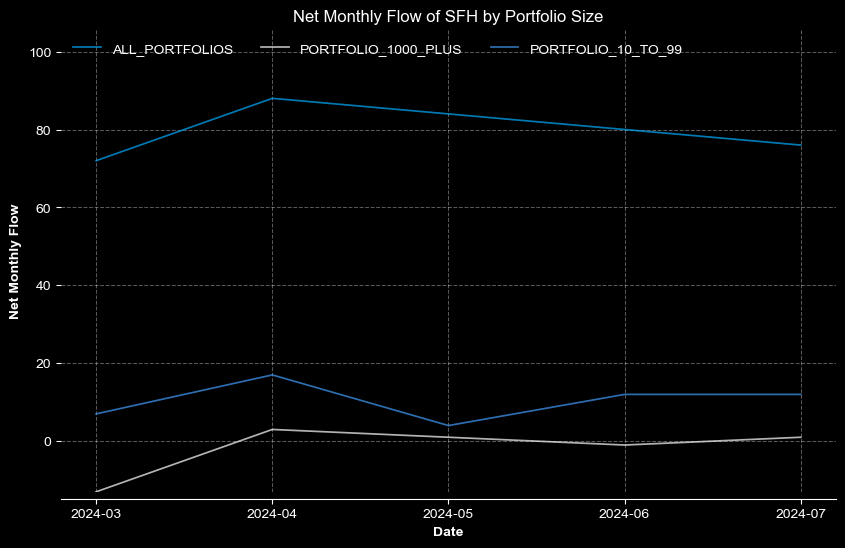

In [12]:
# Concatenate the dataframes for large, mid-sized, and all investors
all_investor_data = pd.concat([large_investor_behavior, mid_investor_behavior, all_investor_behavior])

# Convert 'date' to datetime format for accurate plotting and sort the data
all_investor_data['date'] = pd.to_datetime(all_investor_data['date']).dt.strftime('%Y-%m')
all_investor_data.sort_values(by=['portfolio_size','date'], inplace=True)

# Set the background and line colors to match the previous plot
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Define colors for the line plot
colors_line = ['#00adff', '#FFFFFF', '#419dfa']
categories = all_investor_data['portfolio_size'].unique()

# Plot the line chart for each portfolio size
for index, value in enumerate(categories):
    portfolio_data = all_investor_data[all_investor_data['portfolio_size'] == value]
    ax.plot(portfolio_data['date'], portfolio_data['net_monthly_flow'], label=value, 
            color=colors_line[index], linewidth=1.25, alpha=0.7, zorder=3)

# Customize the spines: remove all but the bottom x-axis spine
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['bottom'].set_color('white')

# Label the axes with bold white text
ax.set_xlabel('Date', color='white', fontweight='bold')
ax.set_ylabel('Net Monthly Flow', color='white', fontweight='bold')

# Add gridlines
ax.grid(axis='x', color='white', linestyle='--', linewidth=0.75, alpha=0.35, zorder=1)  
ax.grid(axis='y', color='white', linestyle='--', linewidth=0.75, alpha=0.35, zorder=1)  

# Format the x-axis dates
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Set the title with white text
ax.set_title('Net Monthly Flow of SFH by Portfolio Size', color='white')

# Add a legend with white text; position it in the top left corner with 3 columns
legend = ax.legend(facecolor='black', frameon=False, framealpha=1, loc='upper left', ncol=3)
for text in legend.get_texts():
    text.set_color('white')

# Set the y-axis limit
ax.set_ylim(all_investor_data['net_monthly_flow'].min(), all_investor_data['net_monthly_flow'].max() * 1.2)

# Set the font family for the plot
plt.rcParams['font.family'] = 'Arial'


# Save the plot as a PNG file
#plt.savefig('downloads/acquisitions_vs_dispositions_various_pf_Milwaukee.png', dpi=400, bbox_inches='tight')

# Show the plot
plt.show()

The behavior for large portfolios indicates that there is not a lot of activity happening at the moment, as they hover around 0 net acquisitions. On the other hand, mid-sized portfolios have been acquiring properties at a steady pace since March 2024. The overall trend for all portfolios is positive, with a slight increase in acquisitions over the last few months. We can take an even deeper look at the trends by visualizing the acquisition and disposition trends of large portfolios over time.


In [13]:
# Change the units of the chart to not display as percentages
style_config['tick_prefix'] = ''

# Create a dual-axis chart to compare acquisitions and dispositions for large portfolios
create_dual_axis_chart(
    title='Acquisitions vs Dispositions for Large Portfolios (1000+) in Milwaukee MSA',
    line_data=large_investor_behavior,
    bar1_data=large_investor_behavior,
    line_series='acquisitions',
    bar1_series='dispositions',
    yaxis1_title='Acquisitions',
    yaxis2_title='Dispositions',  
    height=SIZE_CONFIG['x']['height'],
    width=SIZE_CONFIG['x']['width'],
    style_config=style_config,
    # save_path='tampa_market_price_drops.png' # Uncomment to save the figure
)


We can do the same for mid size portoflios (`10 to 99 units`)

In [14]:
# Change the units of the chart to not display as percentages
style_config['tick_prefix'] = ''

# Create a dual-axis chart to compare acquisitions and dispositions for mid-sized portfolios
create_dual_axis_chart(
    title='Acquisitions vs Dispositions for Mid-Sized Portfolios (10 to 99 Units) in Milwaukee MSA',
    line_data=mid_investor_behavior,
    bar1_data=mid_investor_behavior,
    line_series='acquisitions',
    bar1_series='dispositions',
    yaxis1_title='Acquisitions',
    yaxis2_title='Dispositions',
    height=SIZE_CONFIG['x']['height'],
    width=SIZE_CONFIG['x']['width'],
    style_config=style_config,
    # save_path='tampa_market_price_drops.png' # Uncomment to save the figure
)


The movements in acquisitions and dispositions help us understand how institutional investors approach their portfolio balance in the Milwaukee metro. However, this is not the only analysis we can perform with the API; we can also assess if they are experiencing high vacancy rates as a result of market cool-downs. To obtain this information, we can use the `portfolio_metrics.sf_new_listings_for_rent_rolling_counts` method, which returns data on the number of units each portfolio lists for rent over different time periods (7, 30, 45, 60 days). This can reveal tightening market conditions in terms of inventory. In the next chart, we will examine what share of all their units large portfolios listed for rent over different periods of time. This endpoint starts on `2024-04-22`, so we will modify the `start_date` accordingly. We also need to provide a list of markets (`parcl_ids`) and specify the type of portfolio.



In [15]:
# Retrieve information about new listings for rent by large investors
listings_for_rent_large_investors = client.portfolio_metrics.sf_new_listings_for_rent_rolling_counts.retrieve(
    parcl_ids=[2900134],  # Replace with appropriate Parcl IDs if needed
    portfolio_size='PORTFOLIO_1000_PLUS',  
    start_date='2024-08-20',  # Adjusted start date
    end_date='2024-08-30',
    limit=100  # Limit the number of records retrieved
)

# Display the first few rows of the retrieved data
listings_for_rent_large_investors.head()


,parcl_id,date,count_rolling_7_day,count_rolling_30_day,count_rolling_60_day,count_rolling_90_day,pct_sf_for_rent_market_rolling_7_day,pct_sf_for_rent_market_rolling_30_day,pct_sf_for_rent_market_rolling_60_day,pct_sf_for_rent_market_rolling_90_day,portfolio_size
0,2900134,2024-08-26,5,18,34,54,10.2,7.29,6.28,6.59,PORTFOLIO_1000_PLUS


In [16]:
# Define the order of the columns for rolling periods
sort_columns = ['pct_sf_for_rent_market_rolling_90_day', 'pct_sf_for_rent_market_rolling_60_day',
                'pct_sf_for_rent_market_rolling_30_day', 'pct_sf_for_rent_market_rolling_7_day']

# Melt the dataframe to convert it into a long format suitable for plotting
df_melted = (
    listings_for_rent_large_investors
    .filter(like='pct')  # Filter columns containing percentage data
    .melt(var_name='Rolling Period', value_name='Percentage')  # Reshape the dataframe to long format
    .assign(Percentage=lambda x: x['Percentage'] * 0.01)  # Convert percentages to decimal
    .assign(**{'Rolling Period': lambda df: pd.Categorical(df['Rolling Period'], categories=sort_columns, ordered=True)})
    .sort_values(by='Rolling Period')  # Sort the data based on the defined order
)

# Define a color palette
colors = ['#142872', '#8a9cb7', '#4882db', '#d4d4d4']

# Create the stacked bar chart using Plotly Express
fig = px.bar(df_melted, 
             x='Percentage', 
             y='Rolling Period', 
             barmode='relative', 
             title='Share of Housing Stock Listed for Rent for Large Portfolios over Different Rolling Periods',
             color='Rolling Period',
             color_discrete_sequence=colors
)

fig.update_traces(marker=dict(line=dict(width=0)))

# Customize the layout of the chart
fig.update_layout(
    margin=dict(l=40, r=40, t=100, b=40),  # Increase top margin to accommodate the subtitle
    showlegend=False,
    title={
        'text': 'Share of Housing Stock Listed for Rent for Large Portfolios Over Different Rolling Periods',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': style_config['title_font']
    },
    xaxis=dict(
        title_text='',
        tickformat='.2%',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis'],
        tickfont=dict(size=style_config['axis_font']['size'], color=style_config['axis_font']['color']),
    ),
    yaxis=dict(
        title_text='Housing Stock Listed for Rent',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        tickformat='.1%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=dict(size=18, weight='bold')  # Set y-axis title to bold
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    legend_title_text='',
    autosize=False,
    width=1600,
    height=800,
    title_font=dict(size=24),
    xaxis_title_font=dict(size=18),
    legend_title_font=dict(size=14),
    legend_font=dict(size=12),
    legend=dict(
        x=style_config['legend_x'],
        y=style_config['legend_y'],
        xanchor=style_config['legend_xanchor'],
        yanchor=style_config['legend_yanchor'],
        font=style_config['legend_font'],
        bgcolor='rgba(0, 0, 0, 0)'
    ),
)

# Add the Parcl Labs watermark to the plot
fig.add_layout_image(create_labs_logo_dict())

# Display the chart
fig.show()


Conditions seem to have deteriorated for large portfolios (1000+ units) in the Milwaukee MSA, with the share of housing stock listed for rent increasing across all rolling periods. Let's see if this trend is common across the entire market in Milwaukee. For this, we will use the `rental_market_metrics.new_listings_for_rent_rolling_counts` method of the client, which provides information on the rolling number of new listings for rent for different types of properties. Since we are focusing on single-family homes (SFH), we need to specify that in the `property_type` argument. Additional information about this endpoint can be found [here](https://docs.parcllabs.com/reference/new_listings_for_rent_rolling_counts_v1_rental_market_metrics__parcl_id__new_listings_for_rent_rolling_counts_get-1).


In [17]:
# Retrieve information about new listings for rent across the Milwaukee market
rentals_new_listings_rolling_counts_milwaukee = client.rental_market_metrics.new_listings_for_rent_rolling_counts.retrieve(
    parcl_ids=[2900134],  # Replace with appropriate Parcl IDs if needed
    start_date='2024-06-20',  # Set the start date for data retrieval
    end_date='2024-08-30',    # Set the end date for data retrieval
    property_type='SINGLE_FAMILY',  # Focus on single-family properties
    limit=100  # Limit the number of records retrieved
)

# Print the number of records retrieved
print(len(rentals_new_listings_rolling_counts_milwaukee))

# Display the first 20 rows of the retrieved data
rentals_new_listings_rolling_counts_milwaukee.head(20)


10


,parcl_id,date,rolling_7_day,rolling_30_day,rolling_60_day,rolling_90_day,property_type
0,2900134,2024-08-26,49,247,541,820,SINGLE_FAMILY
1,2900134,2024-08-19,62,274,560,842,SINGLE_FAMILY
2,2900134,2024-08-12,47,290,553,848,SINGLE_FAMILY
3,2900134,2024-08-05,78,309,575,876,SINGLE_FAMILY
4,2900134,2024-07-29,72,291,582,894,SINGLE_FAMILY
5,2900134,2024-07-22,85,284,567,913,SINGLE_FAMILY
6,2900134,2024-07-15,65,260,565,892,SINGLE_FAMILY
7,2900134,2024-07-08,59,271,575,909,SINGLE_FAMILY
8,2900134,2024-07-01,63,283,583,940,SINGLE_FAMILY
9,2900134,2024-06-24,65,274,613,951,SINGLE_FAMILY


In [18]:
# Sort values by date in ascending order
rentals_new_listings_rolling_counts_milwaukee = rentals_new_listings_rolling_counts_milwaukee.sort_values(by='date', ascending=True)

# Calculate the percentage change for each rolling period
rentals_new_listings_rolling_counts_milwaukee = (
    rentals_new_listings_rolling_counts_milwaukee
    .assign(rolling_90_day_pct_change=lambda x: x['rolling_90_day'].pct_change(),
            rolling_60_day_pct_change=lambda x: x['rolling_60_day'].pct_change(),
            rolling_30_day_pct_change=lambda x: x['rolling_30_day'].pct_change(),
            rolling_7_day_pct_change=lambda x: x['rolling_7_day'].pct_change()
            )
    # Drop rows with missing values after calculating percentage changes
    .dropna()
)

# Display the updated dataframe
rentals_new_listings_rolling_counts_milwaukee['date'] = pd.to_datetime(rentals_new_listings_rolling_counts_milwaukee['date'])


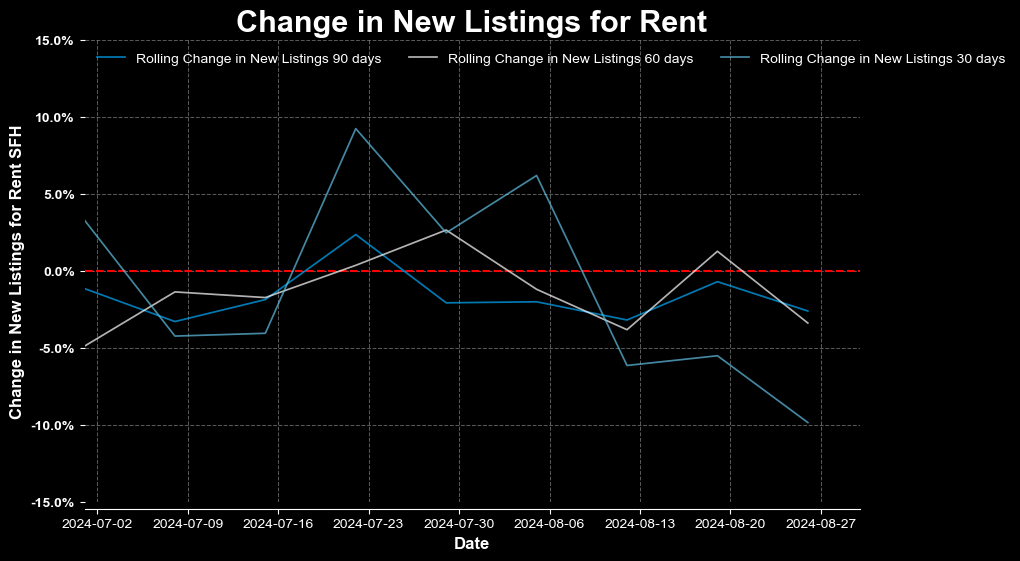

In [19]:
# Set the background and line colors to match the previous plot
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Define colors for the lines
colors_line = ['#00adff','#FFFFFF','#62c1e5']

# Plot the line chart for the rolling 90-day percentage change
ax.plot(rentals_new_listings_rolling_counts_milwaukee['date'], 
        rentals_new_listings_rolling_counts_milwaukee['rolling_90_day_pct_change'], 
        label='Rolling Change in New Listings 90 days', 
        color=colors_line[0], linewidth=1.25, alpha=0.7, zorder=3)

# Plot the line chart for the rolling 60-day percentage change
ax.plot(rentals_new_listings_rolling_counts_milwaukee['date'],
        rentals_new_listings_rolling_counts_milwaukee['rolling_60_day_pct_change'], 
        label='Rolling Change in New Listings 60 days', 
        color=colors_line[1], linewidth=1.25, alpha=0.7, zorder=3)

# Plot the line chart for the rolling 30-day percentage change
ax.plot(rentals_new_listings_rolling_counts_milwaukee['date'],
        rentals_new_listings_rolling_counts_milwaukee['rolling_30_day_pct_change'], 
        label='Rolling Change in New Listings 30 days', 
        color=colors_line[2], linewidth=1.25, alpha=0.7, zorder=3)

# Customize the spines: remove all but the bottom x-axis spine
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['bottom'].set_color('white')

# Label the axes with bold white text
ax.set_xlabel('Date', color='white', fontweight='bold', fontsize=12)
ax.set_ylabel('Change in New Listings for Rent SFH', color='white', fontweight='bold', fontsize=12)

# Add gridlines
ax.grid(axis='x', color='white', linestyle='--', linewidth=0.75, alpha=0.35, zorder=1)  
ax.grid(axis='y', color='white', linestyle='--', linewidth=0.75, alpha=0.35, zorder=1)

# Format the x-axis dates
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Add line around 0 for reference
ax.axhline(0.00, color='red', linewidth=1.5, linestyle='--', zorder=2)


# Set the title with bold white text
ax.set_title('Change in New Listings for Rent', color='white', fontweight='bold', fontsize=22)

# Add a legend with white text, positioned in the top left corner with 3 columns
legend = ax.legend(facecolor='black', frameon=False, framealpha=1, loc='upper left', ncol=3)
for text in legend.get_texts():
    text.set_color('white')

# Set the y-axis limit
ax.set_ylim(-0.15, 0.15)
ax.set_xlim(rentals_new_listings_rolling_counts_milwaukee['date'].min(), pd.to_datetime('2024-08-30'))

# Format y-axis as percentage points and make the numbers bold
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Adjust the interval for more or fewer ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(axis='y', colors='white', labelsize=10)
ax.tick_params(axis='x', colors='white', labelsize=10)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

# Set the font family for the plot
plt.rcParams['font.family'] = 'Arial'

# Save the plot as a PNG file
#plt.savefig('downloads/changes_single_family_rent_Milwaukee_metro.png', dpi=400, bbox_inches='tight')

# Show the plot
plt.show()



Based on this analysis seems that the number of units in the Milwaukee metro market have been trending down which does not bode well for large SFR operators.  